# Predicting User Churn with Apache Spark and AWS EMR

This notebook contains data cleaning, feature creation and ML optimization for the Sparkify dataset.

In [1]:
# imports

# pyspark sql
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import from_unixtime, udf, col, when, isnan, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import isnan, when, count, col

# pyspark ml
from pyspark.ml.feature import VectorAssembler, Normalizer, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# python
import datetime
from typing import NewType
pysparkdf = NewType('pysparkdf', object)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# Build Spark session
spark = SparkSession.builder.appName("user_churn").getOrCreate()

# Read in data
data_df = spark.read.json("../data/01_raw/medium-sparkify-event-data.json")# Build Spark session

## Data Wrangling

In [3]:
def clean_df(data_df):
    """Remove non useful columns and drop missing values for user and session.
    """
    # lets remove some of the columns we don't think will be useful from data exploration
    cols_to_drop = ['firstName', 'lastName','artist', 'song', 'method', 'status', 'userAgent']
    user_log_df = data_df.drop(*cols_to_drop)
    
    # drop rows with missing info
    return user_log_df.dropna(how = "any", subset = ["userId", "sessionId"])
    
user_log_valid = clean_df(data_df)

In [4]:
def unix_to_datetime(data_df):
    """ onvert unix timestamps to datetime.
    """
    # event unix to datetime
    data_df = data_df.withColumn("timestampDatetime",
                                         from_unixtime(user_log_valid.ts/1000,
                                                       format='yyyy-MM-dd HH:mm:ss'))
    # registration unix to datetime
    data_df = data_df.withColumn("registrationDatetime",
                                         from_unixtime(user_log_valid.registration/1000,
                                                       format='yyyy-MM-dd HH:mm:ss'))
    return data_df

user_log_valid = unix_to_datetime(user_log_valid)

In [5]:
def create_us_states(data_df):
    """Create US states column from location.
    """
    # we don't really want to drop these rows as the col isn't vital 
    # so replace missing values to allow split
    data_df = data_df.fillna({'location':'unknown'})

    # define UDFs
    # create state column
    loc_split = udf(lambda x: x.split(', ')[-1], StringType())

    # Sates seem to be appended, so take latest
    state_split = udf(lambda x: x.split('-')[-1], StringType())

    # apply UDFs
    data_df = data_df.withColumn("usStateAbbr",
                                 when(data_df.location.isNotNull(),
                                      loc_split(data_df.location)).otherwise(''))
    data_df = data_df.withColumn("usStateAbbr",
                                 when(data_df.usStateAbbr.isNotNull(),
                                      state_split(data_df.usStateAbbr)).otherwise(''))
    return data_df
    
user_log_valid = create_us_states(user_log_valid)

In [6]:
def replace_missing_gender(data_df):
    """Replace missing gender with 'unknown'.
    """
    return data_df.fillna({'gender':'unknown'})

user_log_valid = replace_missing_gender(user_log_valid)

In [7]:
wrangled_data = user_log_valid.withColumnRenamed("auth", "authLevel").\
                               withColumnRenamed("length", "sessionLength_s").\
                               withColumnRenamed("level", "subLevel").\
                               withColumnRenamed("ts", "unixEventTS").\
                               withColumnRenamed("registration", "unixRegistrationTS")

wrangled_data.show()

+----------+-------+-------------+---------------+--------+--------------------+---------------+------------------+---------+-------------+------+-------------------+--------------------+-----------+
| authLevel| gender|itemInSession|sessionLength_s|subLevel|            location|           page|unixRegistrationTS|sessionId|  unixEventTS|userId|  timestampDatetime|registrationDatetime|usStateAbbr|
+----------+-------+-------------+---------------+--------+--------------------+---------------+------------------+---------+-------------+------+-------------------+--------------------+-----------+
| Logged In|      M|           20|      597.55057|    free|  Corpus Christi, TX|       NextSong|     1532063507000|      292|1538352011000|   293|2018-10-01 01:00:11| 2018-07-20 06:11:47|         TX|
| Logged In|      M|           74|      380.21179|    free|Houston-The Woodl...|       NextSong|     1538069638000|       97|1538352025000|    98|2018-10-01 01:00:25| 2018-09-27 18:33:58|         TX|


## Feature Engineering

In [8]:
def create_phase_feature(data_df: pysparkdf) -> pysparkdf:
    """Use the cancellation to identify churned users.
    """
    # flag any cancellation confirmation events in pages
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    data_df = data_df.withColumn("churn", flag_cancellation_event("page"))

    # search for flags and fill user rows as churned
    windowval = Window.partitionBy("userId").orderBy(desc("unixEventTS")).rangeBetween(Window.unboundedPreceding, 0)
    return data_df.withColumn("label", Fsum("churn").over(windowval))

In [9]:
def avg_items_in_session(data_df: pysparkdf)-> pysparkdf:
    """Calculate avg items in session for each user.
    """
    # calculate metric and join dfs back together
    return data_df.join(data_df.groupBy('userId').avg('itemInSession'),
                               on='userId')

In [10]:
def avg_user_listening_time(data_df: pysparkdf) -> pysparkdf:
    """Calculate average listening time.
    """
    return data_df.join(data_df.groupBy('userId').avg('sessionLength_s'),
                               on='userId')

In [11]:
def recommendation_performance_good(data_df: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    # flag events
    data_df = data_df.withColumn("recc_performance_good_events",
                                 when((data_df["page"] == 'Add to Playlist') |\
                                      (data_df["page"] == 'Add Friend') |\
                                      (data_df["page"] == 'Thumbs Up'),
                                       1).otherwise(0))
    # calculate number
    return data_df.join(data_df.groupBy('userId').sum('recc_performance_good_events'),
                               on='userId')

def recommendation_performance_bad(data_df: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    # flag events
    data_df = data_df.withColumn("recc_performance_bad_events",
                                 when((data_df["page"] == 'Thumbs Down'),
                                       1).otherwise(0))
    # calculate number
    return data_df.join(data_df.groupBy('userId').sum('recc_performance_bad_events'),
                               on='userId')

In [12]:
def system_performance_bad(data_df: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    # flag events
    data_df = data_df.withColumn("sys_performance_bad",
                                 when((data_df["page"] == 'Help') |\
                                      (data_df["page"] == 'Upgrade') |\
                                      (data_df["page"] == 'Error'),
                                       1).otherwise(0))
    # calculate number                                
    return data_df.join(data_df.groupBy('userId').sum('sys_performance_bad'),
                               on='userId')

In [13]:
# create features
wrangled_data = create_phase_feature(wrangled_data)
wrangled_data = avg_items_in_session(wrangled_data)
wrangled_data = avg_user_listening_time(wrangled_data)
wrangled_data = recommendation_performance_good(wrangled_data)
wrangled_data = recommendation_performance_bad(wrangled_data)
wrangled_data = system_performance_bad(wrangled_data)

In [14]:
# create ml features df
ml_features_data = wrangled_data.select('label',
                                        'userId',
                                        'gender',
                                        'usStateAbbr',
                                        col('avg(itemInSession)').alias("avg_item_in_session"),
                                        col('avg(sessionLength_s)').alias('avg_session_length'),
                                        col('sum(recc_performance_good_events)').alias('num_good_recc'),
                                        col('sum(recc_performance_bad_events)').alias('num_bad_recc'),
                                        col('sum(sys_performance_bad)').alias('num_bad_sys'))

In [15]:
user_stats = ml_features_data.groupBy('userId').avg().toPandas()
user_stats = user_stats.drop(labels="userId", axis=1)
user_stats.head()

,avg(label),avg(avg_item_in_session),avg(avg_session_length),avg(num_good_recc),avg(num_bad_recc),avg(num_bad_sys)
0,1.0,33.839416,269.489070,8.0,3.0,2.0
1,1.0,54.832911,253.857506,23.0,5.0,3.0
2,1.0,27.644737,252.804911,13.0,0.0,3.0
3,0.0,27.297619,255.060824,8.0,1.0,2.0
4,1.0,126.100649,250.089836,173.0,15.0,10.0


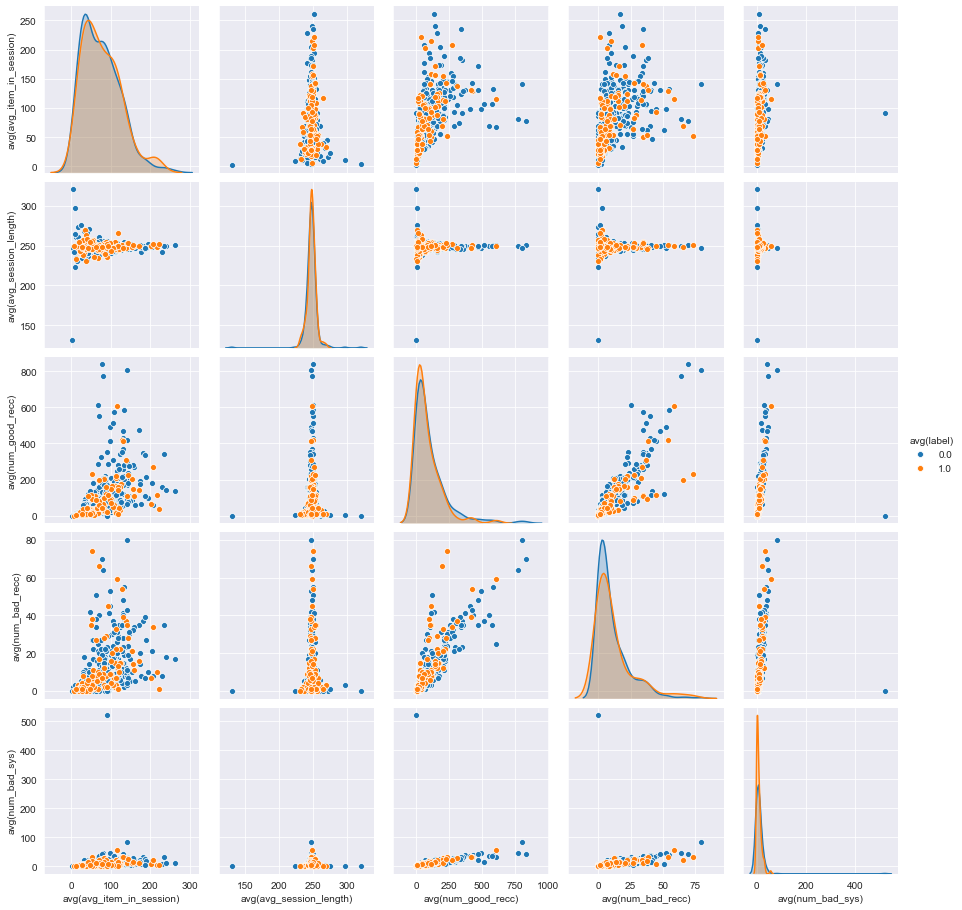

In [16]:
sns.pairplot(user_stats, hue="avg(label)");

In [17]:
def onehot_encoder(ml_features_data):
    ## https://stackoverflow.com/questions/32277576/how-to-handle-categorical-features-with-spark-ml

    cols = ['gender', 'usStateAbbr']

    indexers = [
        StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
        for c in cols
    ]

    encoders = [
        OneHotEncoder(
            inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
        for indexer in indexers
    ]

    assembler = VectorAssembler(
        inputCols=[encoder.getOutputCol() for encoder in encoders],
        outputCol="features2"
    )

    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    return pipeline.fit(ml_features_data).transform(ml_features_data)

ml_features_data = onehot_encoder(ml_features_data)

In [18]:
def vector_assembler(ml_features_data):

    # this vector is created in prep for ml
    assembler = VectorAssembler(inputCols=["avg_item_in_session",
                                           "avg_session_length",
                                           "num_good_recc",
                                           "num_bad_recc",
                                           "num_bad_sys",
                                           'gender_indexed',
                                           'usStateAbbr_indexed'],
                                outputCol="raw_features",
                                handleInvalid="skip")

    return assembler.transform(ml_features_data)

ml_features_data = vector_assembler(ml_features_data)

In [27]:
def feature_scaler(ml_features_data):
    """apply scaler
    """
    scaler = Normalizer(inputCol="raw_features", outputCol="features")
    return scaler.transform(ml_features_data)

ml_df = feature_scaler(ml_features_data)

## Machine Learning

In [28]:
def evaluate_model(results):
    # Generic predictions

    total_results = results.count()
    print('Total user events predicted correctly: {}'.format(results.filter(results.label == results.prediction).count()))
    print('Total user events predicted wrongly: {}'.format(results.filter(results.label != results.prediction).count()))
    print("Percentage predicted correct (%): {} \n".format((results.filter(results.label == results.prediction).count()/total_results)*100))

    churn_correct = results.filter((results.label == 1) & (results.prediction == 1)).count()
    actual_churned_users = results.filter(results.label == 1).count()
    print('User churned and predicted to churn: {}'.format(churn_correct))
    print('Percent churned user events predicted correctly(%): {}\n'.format((churn_correct/actual_churned_users)*100))

    print('Actual non-churned user events in dataset: {}'.format(results.filter(results.label == 0).count()))
    print('Predicted non-churned user events in dataset: {}'.format(results.filter(results.prediction == 0).count()))
    print('Predicted/actual non-churned user events in dataset: {}\n'.format(results.filter(results.prediction == 0).count()/results.filter(results.label == 0).count()))

    print('Number of events predicted to churn but didnt: {}'.format(lr_results.filter((lr_results.label == 0) & (lr_results.label == 1)).count()))

In [29]:
# train test split for ML validation
train, test =  ml_df.randomSplit([0.6, 0.4], seed=42)  # more equal fit to combat overfitting
train.head(5)

[Row(label=1, userId='100010', gender='F', usStateAbbr='CT', avg_item_in_session=33.839416058394164, avg_session_length=269.4890702083333, num_good_recc=8, num_bad_recc=3, num_bad_sys=2, gender_indexed=1.0, usStateAbbr_indexed=22.0, gender_indexed_encoded=SparseVector(2, {1: 1.0}), usStateAbbr_indexed_encoded=SparseVector(45, {22: 1.0}), features2=SparseVector(47, {1: 1.0, 24: 1.0}), raw_features=DenseVector([33.8394, 269.4891, 8.0, 3.0, 2.0, 1.0, 22.0]), features=DenseVector([0.1241, 0.9885, 0.0293, 0.011, 0.0073, 0.0037, 0.0807])),
 Row(label=1, userId='100010', gender='F', usStateAbbr='CT', avg_item_in_session=33.839416058394164, avg_session_length=269.4890702083333, num_good_recc=8, num_bad_recc=3, num_bad_sys=2, gender_indexed=1.0, usStateAbbr_indexed=22.0, gender_indexed_encoded=SparseVector(2, {1: 1.0}), usStateAbbr_indexed_encoded=SparseVector(45, {22: 1.0}), features2=SparseVector(47, {1: 1.0, 24: 1.0}), raw_features=DenseVector([33.8394, 269.4891, 8.0, 3.0, 2.0, 1.0, 22.0]), 

### Baseline Models

In [ ]:
print('Baseline Logistic Regression Model')
lr_model = LogisticRegression().fit(train)
results = lr_model.transform(test)
evaluate_model(results)

In [ ]:
print('Baseline Random Forest Classifier Model')
rfc_model = RandomForestClassifier().fit(train)
results = rfc_model.transform(test)
evaluate_model(results)

In [ ]:
print('Baseline GBT Classifier Model')
gbt_model = GBTClassifier().fit(train)
results = gbt_model.transform(test)
evaluate_model(results)

### Optimised Model

In [30]:
def train_set_evaluator(train):
    """Check for data skew
    """
    print("{} churned user events".format(train.filter(train['label']==1).count()))
    print("{} non-churned user events".format(train.filter(train['label']==0).count()))
    print("{} ratio of churned/non-churned user events".format(train.filter(train['label']==1).count()/train.filter(train['label']==0).count()))
    
train_set_evaluator(train)

62213 churned user events
254839 non-churned user events
0.24412668390630948 ratio of churned/non-churned user events


In [31]:
# pipeline, just running it on classifier no transformations

gbt_model = GBTClassifier()

pipeline = Pipeline(stages=[gbt_model])

# set up param grid to iterate over
paramGrid = ParamGridBuilder() \
.addGrid(gbt_model.maxDepth, [2, 4, 7]) \
.addGrid(gbt_model.maxBins, [15, 40, 50]) \
.addGrid(gbt_model.stepSize, [0.02, 0.2]) \
.build()

# set up crossvalidator to tune parameters and optimize
crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds=3)

In [32]:
cvModel = crossval.fit(train)  # train model
results = cvModel.transform(test)  # apply model on test data

Py4JJavaError: An error occurred while calling o2714.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 173 in stage 445.0 failed 1 times, most recent failure: Lost task 173.0 in stage 445.0 (TID 19124, 192.168.1.228, executor driver): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 65536
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:794)
	at org.apache.spark.unsafe.map.BytesToBytesMap.<init>(BytesToBytesMap.java:200)
	at org.apache.spark.unsafe.map.BytesToBytesMap.<init>(BytesToBytesMap.java:207)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.<init>(UnsafeFixedWidthAggregationMap.java:101)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.createHashMap(HashAggregateExec.scala:434)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage92.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage92.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$1.hasNext(InMemoryRelation.scala:132)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:99)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:66)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:64)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:227)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:235)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:235)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:184)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 65536
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:794)
	at org.apache.spark.unsafe.map.BytesToBytesMap.<init>(BytesToBytesMap.java:200)
	at org.apache.spark.unsafe.map.BytesToBytesMap.<init>(BytesToBytesMap.java:207)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.<init>(UnsafeFixedWidthAggregationMap.java:101)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.createHashMap(HashAggregateExec.scala:434)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage92.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage92.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage93.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage94.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage95.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.agg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage96.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.findNextInnerJoinRows$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage97.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:748)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$1.hasNext(InMemoryRelation.scala:132)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:99)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more


In [25]:
evaluate_model(results)

NameError: name 'results' is not defined

In [26]:
cvModel.avgMetrics  # look at model scoring metrics

NameError: name 'cvModel' is not defined